In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer

utils.set_random_seed(42)


2024-04-12 17:48:04.344054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 17:48:04.344112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 17:48:04.344843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 17:48:04.351046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:48:05.141764: W tensorflow/compiler/tf2

In [2]:
# This might help with memory issues (at least it did on my computer)
class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        #tf.keras.backend.clear_session()

#### Dataset Preparation

In [1]:
NODES_TO_TRAIN = ['AD', 'IK']   # Set this to all the nodes you want to train (from AD, IK, ID). The final submission contained one AD+IK and one ID model

In [4]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_2/')
train_val_data_dir = challenge_data_dir / "training"
train_val_labels_dir = challenge_data_dir / 'train_label.csv'

train_val_df_dict = datahandler.load_and_prepare_dataframes(train_val_data_dir, train_val_labels_dir, dtype=np.float32)

In [6]:
# Create the dataset generator - this is where most of the preprocessing happens
# A more detailed documentation of the different paramters can be found in the DatasetGenerator implementation
ds_gen = datahandler.DatasetGenerator(
                                    # Input Data
                                    train_val_df_dict=train_val_df_dict,
                                    exclude_objects=[30, 113, 1012, 1383, 1385, 1386, 1471, 1473, 1474],

                                    # General dataset settings
                                    padding='zero',
                                    train_val_split=0.8,
                                    unify_value_ranges=True,

                                    # Input horizons & Stride
                                    input_history_steps=128,
                                    input_future_steps=32,
                                    input_stride=2,

                                    # Input feature selection
                                    non_transform_features=['Eccentricity',
                                                            'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            'Latitude (deg)'],
                                    diff_transform_features=[#'Eccentricity',
                                                            #'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            'True Anomaly (deg)',
                                                            'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                            ],
                                    sin_transform_features=[#'Eccentricity',
                                                            #'Semimajor Axis (m)',
                                                            #'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                            ],
                                    sin_cos_transform_features=[],
                                    overview_features_mean=[#'Longitude (sin)',
                                                            #'RAAN (deg)'
                                                            ],
                                    overview_features_std=[#'Inclination (deg)'
                                                            ],
                                    add_daytime_feature=False,
                                    add_yeartime_feature=False,
                                    add_linear_timeindex=False,

                                    # Transformation details
                                    legacy_diff_transform=False,
                                    scale=True,
                                    custom_scaler=None,
                                    per_object_scaling=False,
                                    linear_timeindex_as_overview=True,
                                    
                                    # Label generation details
                                    nodes_to_include_as_locations=NODES_TO_TRAIN,
                                    with_labels=True,
                                    nonbinary_padding=[110.0, 70.0, 49.0, 34.0, 24.0, 12.0],
                                    node_class_multipliers={'ID':0.0,'IK':0.0,'AD':0.0,'SS':0.0}.update({node:1.0 for node in NODES_TO_TRAIN}),

                                    # Miscellaneous
                                    seed=11,
                                    deepcopy=True,
                                    input_dtype=np.float32,
                                    verbose=2)

=========================Creating Generator=======================
Seed: 11
nTrain: 1796 nVal: 95 nTest: 0 (train-val-split: 0.95)
Padding: zero
Horizons: 128-32 @ stride 2
Scaling: True  
Node Class Multipliers: {'ID': 0.0, 'IK': 1.0, 'AD': 1.0, 'SS': 0.0}
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Inclination (deg)', 'True Anomaly (deg)', 'Longitude (deg)']
Wraparound offset for ft Inclination (deg): []
Wraparound offset for ft True Anomaly (deg): [270, -90]
Wraparound offset for ft Longitude (deg): [180, -180]
Scaling now.
Adding nb padding now.
Padding node locations in non-binary fashion ([12.0, 24.0, 34.0, 49.0, 70.0, 110.0, 70.0, 49.0, 34.0, 24.0, 12.0])
Fitting Labelencoders now.
Dropping 22 unused columns now.
Final 9 input features: ['Argument of Periapsis (sin)', 'Eccentricity', 'Inclination (deg)', 'Inclination (deg) (diff)',

In [11]:
# Fetch a dataset just to get the shapes
datasets = ds_gen.get_datasets(2048,
                                label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                shuffle=True,
                                only_ew_sk=False,
                                stride=1,
                                keep_label_stride=110,
                                verbose=1)
print(datasets['val'].element_spec) # 669765 167541

100%|██████████| 95/95 [00:01<00:00, 82.30it/s]


DS-Cardinalities: ['train: 35955', 'val: 1902']
({'local_in': TensorSpec(shape=(None, 80, 9), dtype=tf.float32, name=None)}, {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


In [ ]:
# Plot a dataset item to exam how the model's inputs look
ds_gen.plot_dataset_item(datasets['val'], objectid=163, timeindex=2104)

#### Model Training

(You can also skip this section and go right to the evaluation section and load a pre-trained model)

In [27]:
# Create the model
model = prediction_models.Dense_NN(datasets['val'],
                                    conv1d_layers=[[64,7,1,1,1],[64,7,1,1,1],[48,7,2,1,1]],
                                    dense_layers=[64,32],
                                    l2_reg=0.00025,
                                    mixed_batchnorm_cnn=True,
                                    mixed_dropout_dense=0.05,
                                    mixed_dropout_cnn=0.1,
                                    lr_scheduler=[0.005],
                                    output_type='regression',
                                    final_activation=None,
                                    final_activation_bias_initializer=None,#tf.keras.initializers.Constant(-6.08), <- helps with binary prediction
                                    asymmetric_loss=0.0, # value<0 to penalize underestimation more
                                    seed=0)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 local_in (InputLayer)       [(None, 80, 9)]              0         []                            
                                                                                                  
 conv1d_0_local (Conv1D)     (None, 74, 64)               4096      ['local_in[0][0]']            
                                                                                                  
 conv1d_BN_0_local (BatchNo  (None, 74, 64)               256       ['conv1d_0_local[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 conv1d_relu_0_local (Activ  (None, 74, 64)               0         ['conv1d_BN_0_local[0][0

In [7]:
# save some more memory :)
del datasets
gc.collect()

503

In [ ]:
# Perform the actual training in a custom training loop, so that an offset can be applied to the dataset stride inbetween

for strides, offset, keep_label, epochs in [[5,0,True,45],[5,3,True,45]]:
    print(f"Strides: {strides} Offset: {offset} Keeping Label: {keep_label}")
    datasets = ds_gen.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1 if keep_label else strides,
                                          keep_label_stride=1 if not keep_label else strides,
                                          stride_offset=offset,
                                          verbose=1)
    
    # For custom class weights:
    #train_ns= train_ns.map(lambda x,y:(x,y[f'EW_Node_Location']))
    #val_ns = val_ns.map(lambda x,y:(x,y[f'EW_Node_Location']))
    #class_weights = {0:0.5, 1:2.0}

    hist = model.fit(datasets['train'],
                        val_ds=datasets['val'],
                        epochs=epochs,
                        verbose=2,
                        plot_hist=True,
                        early_stopping=0,
                        target_metric='val_mse',
                        #class_weight=class_weights,
                        save_best_only=False,
                        callbacks=[ClearMemoryCallback()])
    
    del datasets
    
    print("====================Evaluating======================")
    scores = localizer.perform_evaluation_pipeline(ds_gen,
                                      model,
                                      'val',
                                      gt_path = train_val_labels_dir,
                                      output_dirs=['EW', 'NS'],
                                      prediction_batch_size=96,
                                      thresholds = np.linspace(30.0, 75.0, 12),
                                      object_limit=None,
                                      with_initial_node=False,
                                      nodes_to_consider=NODES_TO_TRAIN,
                                      prediction_stride=1,
                                      verbose=0)
    print("====================================================")

    gc.collect()

print("Done.")

Strides: 5 Offset: 0 Keeping Label: True


  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 1520/1520 [00:16<00:00, 90.69it/s]
2024-02-28 22:30:09.891644: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5486714880 exceeds 10% of free system memory.
100%|██████████| 380/380 [00:04<00:00, 92.58it/s]


Train-DS Cardinality: tf.Tensor(669765, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(167541, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/20


KeyboardInterrupt: 

#### Evaluation

In [8]:
# OPTIONAL: load a model
# model = tf.keras.models.load_model("models/model_1s7se45i.hdf5", compile=False )

2024-03-18 02:07:23.030051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 02:07:23.030358: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [28]:
scores = localizer.perform_evaluation_pipeline(ds_gen,
                                        model=model,
                                        ds_type='val',
                                        gt_path = train_val_labels_dir,
                                        convolve_input_stride=False,
                                        output_dirs=['EW', 'NS'],
                                        prediction_batch_size=96, # this can probably be increased for computers > potato
                                        thresholds = np.linspace(30.0, 80.0, 12), # The thresholds to examine
                                        object_limit=None,
                                        with_initial_node=False,
                                        nodes_to_consider=NODES_TO_TRAIN,
                                        legacy_postprocessing=False,
                                        verbose=1)

196/196 [==============================] - 4s 18ms/step
Threshold: 10.0	 Precision: 0.62 Recall: 0.72 F2: 0.701 RMSE: 2.35 | TP: 511 FP: 316 FN: 194 (ID: 7|355 IK: 240|193 AD: 271|1)
Threshold: 15.0	 Precision: 0.72 Recall: 0.85 F2: 0.819 RMSE: 1.98 | TP: 598 FP: 235 FN: 107 (ID: 5|357 IK: 326|107 AD: 272|0)
Threshold: 20.0	 Precision: 0.80 Recall: 0.96 F2: 0.924 RMSE: 1.45 | TP: 677 FP: 167 FN: 28 (ID: 4|358 IK: 405|28 AD: 272|0)
Threshold: 25.0	 Precision: 0.84 Recall: 0.98 F2: 0.945 RMSE: 1.20 | TP: 689 FP: 136 FN: 16 (ID: 2|360 IK: 417|16 AD: 272|0)
Threshold: 30.0	 Precision: 0.87 Recall: 0.98 F2: 0.955 RMSE: 1.01 | TP: 690 FP: 103 FN: 15 (ID: 1|361 IK: 418|15 AD: 272|0)
Threshold: 35.0	 Precision: 0.89 Recall: 0.98 F2: 0.958 RMSE: 0.86 | TP: 689 FP: 87 FN: 16 (ID: 0|362 IK: 418|15 AD: 271|1)
Threshold: 40.0	 Precision: 0.90 Recall: 0.98 F2: 0.961 RMSE: 0.87 | TP: 689 FP: 75 FN: 16 (ID: 0|362 IK: 418|15 AD: 271|1)
Threshold: 45.0	 Precision: 0.92 Recall: 0.98 F2: 0.966 RMSE: 0.90 

In [ ]:
# save the new model & scaler
model.save('models/new_localizer.hdf5')
pickle.dump(ds_gen.scaler, open('models/new_localizer_scaler.pkl', 'wb'))

204/204 - 2s - 2s/epoch - 10ms/step
(265,)


/home/david/Code/splid-challenge/base/localizer.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[timeindex-20:timeindex+20, 'keep'] = True
/home/david/Code/splid-challenge/base/localizer.py:153: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


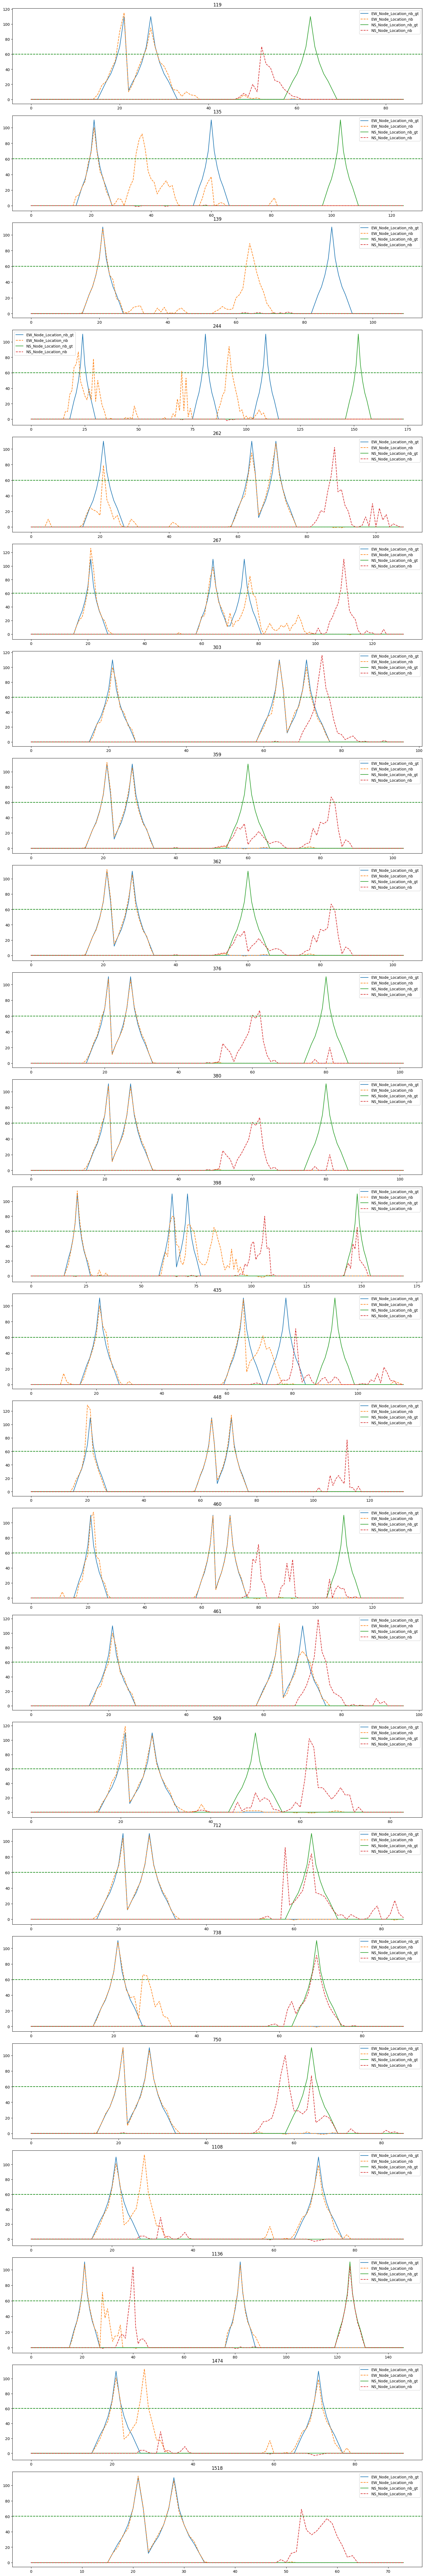

In [65]:
# Plot the raw outputs and labels for some objects, to visualize the linear labels
localizer.plot_prediction_curve(ds_gen=ds_gen,
                                model=model,
                                label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                object_ids=ds_gen.val_keys[105:110],
                                threshold=50.0,
                                zoom=True)